Predicting Stock Prices Using LSTM: An Analysis of Time Series Data

This project walks you through the end-to-end data science lifecycle of developing a predictive model for stock price movements with Alpha Vantage APIs and a powerful machine learning algorithm called Long Short-Term Memory (LSTM). By completing this project, you will learn the key concepts of machine learning / deep learning and build a fully functional predictive model for the stock market, all in a single Python file.

The prediction of stock prices has always been a challenging task due to the inherent complexities and uncertainties in financial markets. However, advancements in deep learning techniques, such as Long Short-Term Memory (LSTM) neural networks, have shown promise in capturing temporal patterns and making accurate predictions in time series data. In this analysis, we explore the application of LSTM models to predict stock prices using historical data. We employ a comprehensive approach that involves data preprocessing, model training, and evaluation, along with insightful visualizations to understand the model's performance.

In [1]:
#@title Load Python libraries

! pip install alpha_vantage -q

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

     |████████████████████████████████| 1.3MB 16.0MB/s 
     |████████████████████████████████| 296kB 50.6MB/s 
     |████████████████████████████████| 143kB 48.5MB/s 
All libraries loaded


This code is used to load several Python libraries that are required for further operations. 

The first line installs the "alpha_vantage" library using the pip package manager. This library provides access to financial data, specifically stock market data. The `-q` flag makes the installation process quiet, so it doesn't display unnecessary output.

Next, the code imports several libraries using the `import` statements. These libraries are numpy, torch, torch.nn, torch.nn.functional, torch.optim, torch.utils.data, matplotlib.pyplot, and matplotlib.pyplot.figure. Each library serves a different purpose in data analysis and machine learning.

The `import numpy as np` statement imports the numpy library and assigns it the alias "np." Numpy is a powerful library for numerical computations and provides efficient data structures and functions.

The `import torch` statement imports the torch library, which is a popular deep learning framework. It provides functionalities for building and training neural networks.

The `import torch.nn as nn` statement imports the torch.nn module, which contains classes for creating neural network layers and architectures.

The `import torch.nn.functional as F` statement imports the torch.nn.functional module, which contains various activation functions and other operations commonly used in neural networks.

The `import torch.optim as optim` statement imports the torch.optim module, which provides optimization algorithms for training neural networks.

The `from torch.utils.data import Dataset` statement imports the Dataset class from the torch.utils.data module. This class is used for creating custom datasets to feed into neural networks.

The `from torch.utils.data import DataLoader` statement imports the DataLoader class from the torch.utils.data module. This class is used for loading and batching data from a dataset during the training process.

The `import matplotlib.pyplot as plt` statement imports the pyplot module from the matplotlib library. This module provides functions for creating visualizations, such as plots and charts.

The `from matplotlib.pyplot import figure` statement imports the figure function from the pyplot module. This function is used to create a figure object that can be customized for plotting.

The `from alpha_vantage.timeseries import TimeSeries` statement imports the TimeSeries class from the alpha_vantage.timeseries module. This class allows fetching historical stock market data using the Alpha Vantage API.

Finally, the code prints the message "All libraries loaded" to indicate that the libraries have been successfully imported.

In [2]:
config = {
    "alpha_vantage": {
        "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

This code defines a configuration dictionary with various settings and parameters for a data analysis and modeling task.

Under the "alpha_vantage" key, the dictionary contains information related to the Alpha Vantage API, which provides financial market data. It includes the API key, which needs to be obtained from the Alpha Vantage website, the symbol of the stock (in this case, "IBM"), the desired output size ("full" for all available data), and the key for the adjusted closing price in the data.

Under the "data" key, the dictionary specifies parameters related to the data processing. It includes the window size, which determines the number of previous data points to consider for prediction, and the train split size, which determines the proportion of data to be used for training the model.

Under the "plots" key, the dictionary defines parameters related to the visualizations. It specifies whether to show plots, the interval of x-axis ticks on the plots, and the colors for different elements of the plots, such as actual data, training data, validation data, and predicted data.

Under the "model" key, the dictionary sets parameters for the neural network model. It includes the input size (1 in this case, as only the closing price is used as a feature), the number of LSTM layers, the size of each LSTM layer, and the dropout rate for regularization.

Under the "training" key, the dictionary provides parameters for the training process. It specifies the device to be used for training ("cpu" or "cuda" for GPU), the batch size for training data, the number of epochs (iterations) for training, the learning rate for the optimizer, and the step size for the learning rate scheduler.

By organizing all these settings and parameters in a configuration dictionary, it allows for easy access and modification of these values in the code, making it more flexible and customizable for different scenarios.

Data preparation: acquiring financial market data from Alpha Vantage

Number data points: 5417 from 1999-11-01 to 2021-05-12


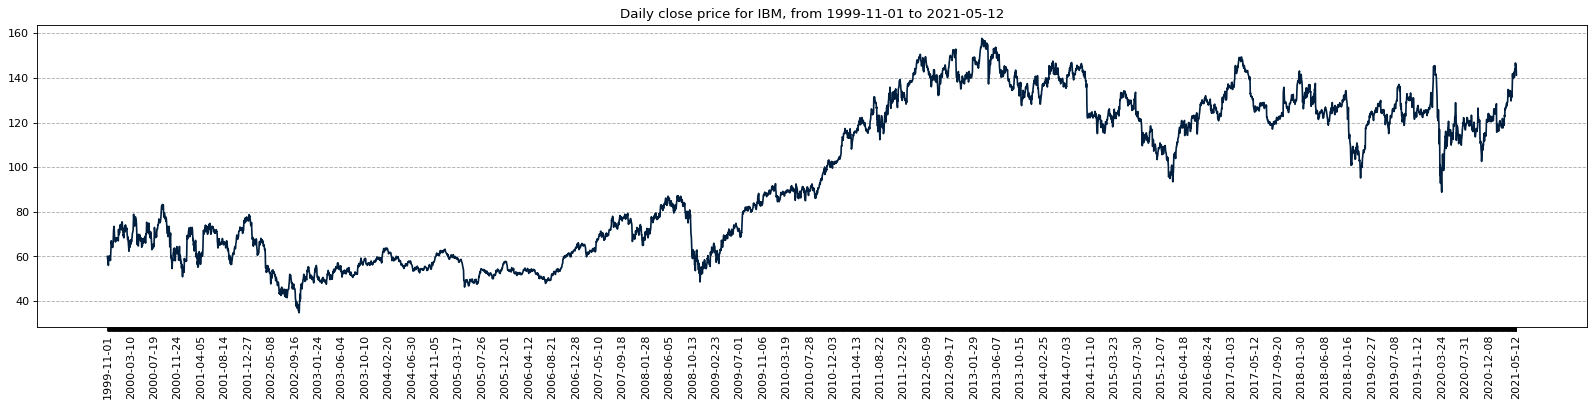

In [3]:
def download_data(config, plot=False):
    # get the data from alpha vantage

    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

The code defines a function called "download_data" that is responsible for downloading and processing financial market data using the Alpha Vantage API. It takes two parameters: "config," which is a dictionary containing various settings and parameters, and "plot," a boolean flag indicating whether to generate a plot or not.

Within the function, the data is fetched from the Alpha Vantage API using the provided API key and symbol specified in the configuration. The "TimeSeries" class from the "alpha_vantage.timeseries" module is used for this purpose. The retrieved data is stored in the "data" variable, and additional metadata about the data is stored in the "meta_data" variable.

The function then proceeds to process the retrieved data. It first extracts the dates from the data and reverses the order to ensure that the dates are in chronological order. The reversed dates are stored in the "data_date" list.

Next, the function extracts the adjusted closing prices from the data. It retrieves the corresponding values for each date, converts them to floating-point numbers, and stores them in the "data_close_price" list. The list is then converted into a numpy array for further processing.

The function calculates the number of data points by obtaining the length of the "data_date" list. It also creates a string called "display_date_range" that represents the range of dates in the data, using the first and last dates from the "data_date" list.

If the "plot" parameter is set to True, the function generates a plot using the matplotlib library. It creates a figure object with customized dimensions and background color. The function plots the dates on the x-axis and the corresponding closing prices on the y-axis, using the colors specified in the configuration. It also adjusts the x-axis ticks to display a selected interval of dates.

Finally, the function returns several variables: "data_date," which is the list of dates; "data_close_price," which is the numpy array of adjusted closing prices; "num_data_points," which is the number of data points in the dataset; and "display_date_range," which is the string representing the range of dates.

By calling this function and providing a configuration, you can download financial market data, process it, and optionally visualize it using a plot. The returned data can be used for further analysis or modeling purposes.

Data preparation: normalizing raw financial data

In [4]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

This code defines a class called "Normalizer" that is used for normalizing data. 

The class has three methods: __init__(), fit_transform(), and inverse_transform().

The __init__() method initializes the class and sets the attributes "mu" and "sd" to None. These attributes will be used to store the mean and standard deviation of the data.

The fit_transform() method takes in an input data array, "x", and performs the normalization process. It calculates the mean and standard deviation of the data along the 0th axis (columns) using the numpy functions np.mean() and np.std(). The calculated mean and standard deviation are stored in the "mu" and "sd" attributes of the class, respectively.

The method then applies the normalization formula to the data by subtracting the mean and dividing by the standard deviation. The normalized data is returned as "normalized_x".

The inverse_transform() method takes in a normalized data array, "x", and performs the inverse normalization process. It multiplies the normalized data by the standard deviation and adds the mean back to obtain the original scale of the data. The inverse-transformed data is returned.

Outside the class, an instance of the "Normalizer" class is created with the variable name "scaler". This instance can be used to normalize data using the fit_transform() method.

The code then applies the fit_transform() method to the "data_close_price" array, storing the normalized data in the "normalized_data_close_price" variable. The "data_close_price" array is passed as the input to the fit_transform() method, which calculates the mean and standard deviation of the data and performs the normalization process.

Overall, this code provides a reusable class for normalizing data, allowing you to transform data to a standard scale before using it in various data analysis or machine learning tasks.

Data preparation: generating training and validation datasets

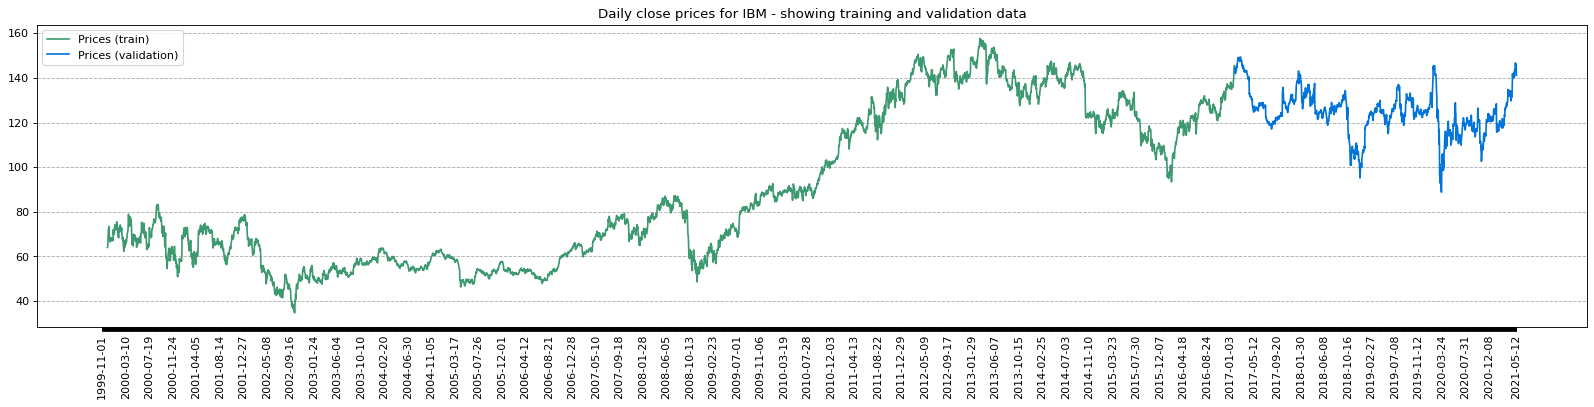

In [5]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])

This code defines a set of functions that are used to prepare the data for a forecasting task based on a given configuration.

The first function, "prepare_data_x," performs a windowing operation on the input data array, "x." It calculates the number of rows in the output array based on the difference between the number of rows in "x" and the window size. Then, using the numpy function "as_strided," it creates a new array with a sliding window of size "window_size" over "x." The function returns two arrays: the windowed data without the last row and the last row of the windowed data.

The second function, "prepare_data_y," prepares the target values for the forecasting task. It takes the input data array, "x," and the window size. In this case, it simply selects the values from "x" starting from the "window_size" index and returns them as the output array.

The third function, "prepare_data," uses the previous two functions to prepare the input and target data for training and validation. It takes the normalized data of the closing prices, the configuration dictionary, and a flag indicating whether to generate plots or not.

Using the "prepare_data_x" function, it generates the windowed input data arrays, "data_x" and "data_x_unseen." It uses the window size specified in the configuration to determine the size of the sliding window. 

Using the "prepare_data_y" function, it generates the target data array, "data_y," by selecting the corresponding target values based on the window size.

The function then splits the dataset into training and validation sets based on the specified train split size in the configuration. The split index is calculated as a proportion of the number of target values, and the input and target data are split accordingly.

If the plot flag is set to True, the function generates a plot to visualize the training and validation data. It prepares the data for plotting by inverse-transforming the target values using the "inverse_transform" method of the "Normalizer" class. It creates a figure, sets the dimensions and background color, and plots the training and validation data using the colors specified in the configuration. The x-axis ticks are adjusted to display a selected interval of dates.

Finally, the function returns several variables: "split_index," which represents the index where the dataset is split between training and validation sets; "data_x_train" and "data_y_train," which are the input and target data for the training set; "data_x_val" and "data_y_val," which are the input and target data for the validation set; and "data_x_unseen," which is the windowed input data for unseen predictions.

By calling this function and providing the necessary inputs, you can prepare the data for a forecasting task, splitting it into training and validation sets and optionally visualizing the data. The returned variables can be used for training a model and evaluating its performance.

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (4317, 20, 1) (4317,)
Validation data shape (1080, 20, 1) (1080,)


This code defines a class called "TimeSeriesDataset" that represents a dataset for time series analysis and forecasting tasks.

The class inherits from the PyTorch "Dataset" class, which provides a standard interface for accessing and manipulating datasets in PyTorch.

In the "__init__" method, the class takes two arguments: "x" and "y," which represent the input and target data for the time series analysis task. The input data, "x," is expanded by adding a new dimension at axis 2 using the "np.expand_dims" function. This expansion is necessary because the data has only one feature, and for LSTM models, the input shape should be [batch, sequence, features]. The expanded input data and target data are then stored in the class attributes "self.x" and "self.y," respectively.

The "__len__" method is implemented to return the length of the dataset, which corresponds to the length of the input data "x." This allows for easy access to the size of the dataset using the "len" function.

The "__getitem__" method is implemented to retrieve an item from the dataset at a specific index "idx." It returns a tuple containing the input data and the corresponding target data at that index.

Outside the class, the code creates two instances of the "TimeSeriesDataset" class: "dataset_train" and "dataset_val." These instances are initialized with the training and validation input and target data, respectively.

Finally, the code prints the shapes of the training and validation data using the "x" and "y" attributes of the dataset instances. This provides information about the dimensions of the input and target data arrays.

In summary, this code defines a custom dataset class, "TimeSeriesDataset," that can be used to represent time series data for analysis and forecasting tasks. It provides functionalities to access individual items in the dataset and retrieves the input and target data at a specific index.

Defining the LSTM model

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

This code defines a class called "LSTMModel" that represents a Long Short-Term Memory (LSTM) neural network model for time series forecasting.

The class inherits from the PyTorch "nn.Module" class, which is the base class for all neural network modules in PyTorch.

In the "__init__" method, the class takes several arguments to initialize the model. These include the input size, hidden layer size, number of LSTM layers, output size, and dropout rate. The input size represents the number of features in the input data, while the hidden layer size determines the number of units in the LSTM layers.

Within the "__init__" method, the model's architecture is defined. It consists of a linear layer, an activation function (ReLU), an LSTM layer, a dropout layer, and another linear layer. The linear layers are used for transforming the input data, and the LSTM layer is responsible for learning temporal patterns in the data.

The "init_weights" method is implemented to initialize the weights of the LSTM layer. It iterates over the parameters of the LSTM layer and applies specific weight initialization techniques depending on the parameter's name, such as setting biases to zero, using a kaiming normal initialization for input weights, and applying an orthogonal initialization for recurrent weights.

The "forward" method defines the forward pass of the model. It takes an input tensor, "x," as its argument. The input tensor is first passed through the linear layer, followed by the ReLU activation function. Then, the tensor is passed through the LSTM layer, which produces the LSTM output and the hidden and cell states. The output is reshaped to have dimensions [batch, features] and passed through the dropout layer. Finally, the output is passed through the last linear layer to obtain the predictions. The predictions are returned, taking only the last element of the output tensor.

Outside the class, an instance of the "LSTMModel" class is created using the provided configuration settings. The configuration is used to specify the input size, hidden layer size, number of LSTM layers, and dropout rate.

The model is then moved to the device specified in the configuration, which can be either "cpu" or "cuda" (GPU). This allows for utilizing hardware acceleration during the training process.

In summary, this code defines a custom LSTM model for time series forecasting. It sets up the architecture of the model, initializes the weights of the LSTM layer, defines the forward pass logic, and creates an instance of the model based on the provided configuration. The model is then moved to the specified device for further training and evaluation.

Model training

In [8]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


Epoch[1/100] | loss train:0.050537, test:0.001879 | lr:0.010000
Epoch[2/100] | loss train:0.010868, test:0.001240 | lr:0.010000
Epoch[3/100] | loss train:0.009598, test:0.001956 | lr:0.010000
Epoch[4/100] | loss train:0.008986, test:0.001376 | lr:0.010000
Epoch[5/100] | loss train:0.008774, test:0.001042 | lr:0.010000
Epoch[6/100] | loss train:0.009519, test:0.001311 | lr:0.010000
Epoch[7/100] | loss train:0.007898, test:0.001013 | lr:0.010000
Epoch[8/100] | loss train:0.007705, test:0.001066 | lr:0.010000
Epoch[9/100] | loss train:0.008269, test:0.001146 | lr:0.010000
Epoch[10/100] | loss train:0.007613, test:0.001178 | lr:0.010000
Epoch[11/100] | loss train:0.008015, test:0.001181 | lr:0.010000
Epoch[12/100] | loss train:0.007816, test:0.001232 | lr:0.010000
Epoch[13/100] | loss train:0.007499, test:0.002633 | lr:0.010000
Epoch[14/100] | loss train:0.008146, test:0.001044 | lr:0.010000
Epoch[15/100] | loss train:0.007939, test:0.001271 | lr:0.010000
Epoch[16/100] | loss train:0.00865

This code contains several functions and a training loop to train an LSTM model for a time series forecasting task.

The "run_epoch" function is defined to run a single epoch of training or evaluation. It takes a dataloader as input, which provides batches of data, and a flag "is_training" to indicate whether it is a training or evaluation epoch. 

Inside the function, an epoch_loss variable is initialized to keep track of the loss accumulated during the epoch.

If it is a training epoch, the model is set to training mode using "model.train()". Otherwise, it is set to evaluation mode using "model.eval()". These modes affect how certain layers, such as dropout, behave during training and evaluation.

The function then iterates over the batches in the dataloader. For each batch, the optimizer's gradients are zeroed if it is a training epoch using "optimizer.zero_grad()". The input data, "x," and target data, "y," are retrieved from the batch.

The input and target data are moved to the device specified in the configuration using ".to(config["training"]["device"])". This ensures that the data is processed on the correct hardware (CPU or GPU).

The model is then called with the input data, "x," to obtain the model's output, "out". The loss between the output and the target data is calculated using the specified loss function, "criterion".

If it is a training epoch, the loss is backpropagated through the model and the optimizer's step function is called using "loss.backward()" and "optimizer.step()" to update the model's parameters.

The batch loss is accumulated to the epoch_loss variable, taking into account the batch size.

The learning rate for the epoch is obtained from the learning rate scheduler using "scheduler.get_last_lr()".

Finally, the function returns the epoch_loss and the learning rate.

Outside the function, a training and validation dataloader are created using the training and validation datasets.

An optimizer, scheduler, and loss function are defined. The optimizer is an Adam optimizer with the model's parameters and the learning rate specified in the configuration. The scheduler is a StepLR scheduler that adjusts the learning rate based on the specified step size and gamma values. The loss function is the mean squared error (MSE) loss.

The training loop starts with a for loop that iterates over the number of epochs specified in the configuration. For each epoch, the loss and learning rate are computed by calling the "run_epoch" function on the training and validation dataloaders.

The learning rate scheduler's step function is called to update the learning rate.

The loss values and learning rates are then printed to track the progress of training.

In summary, this code sets up the training process for the LSTM model. It defines a function to run a single epoch of training or evaluation, creates dataloaders for training and validation data, initializes an optimizer, scheduler, and loss function, and then executes the training loop for the specified number of epochs. During each epoch, the model is trained on the training data and evaluated on the validation data, and the loss values are printed for monitoring the training progress.

Model evaluation

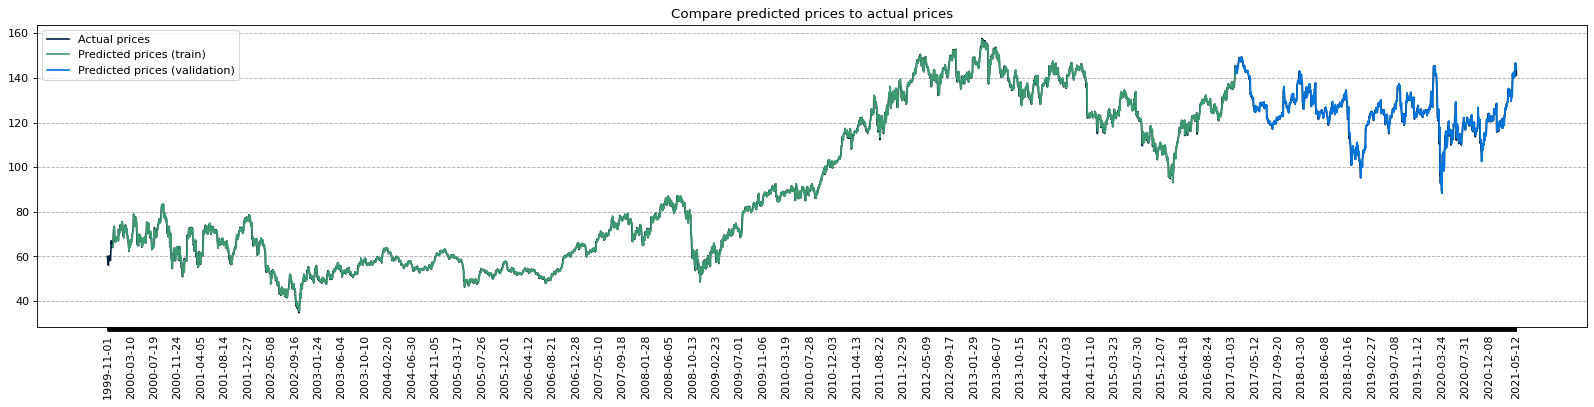

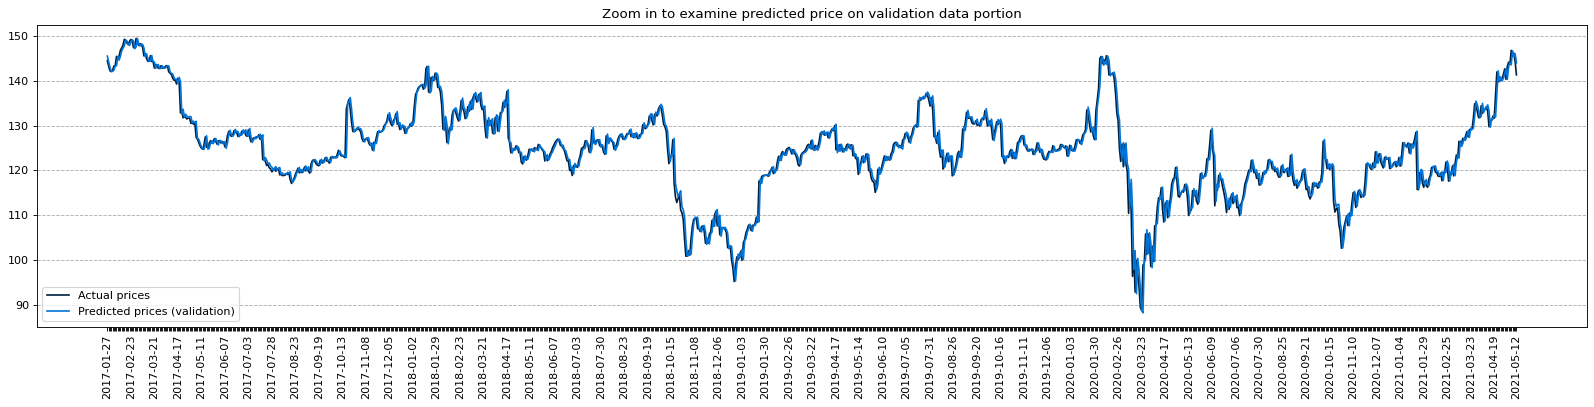

In [9]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

This code performs predictions using the trained LSTM model and generates plots to compare the predicted prices with the actual prices.

First, the dataloaders for training and validation data are re-initialized without shuffling the data. This is done to ensure that the order of the data is preserved for plotting purposes.

The model is set to evaluation mode using "model.eval()" to deactivate certain layers, such as dropout, that behave differently during training and evaluation.

The code then performs predictions on the training data by iterating over the batches in the training dataloader. The input data, "x," is moved to the device specified in the configuration, and the model is called with the input data to obtain the predictions. The predictions are converted to a numpy array and concatenated with the previous predictions.

Similarly, predictions are performed on the validation data by iterating over the batches in the validation dataloader. The input data is moved to the device, and the model is used to obtain the predictions. Again, the predictions are converted to a numpy array and concatenated.

If the "show_plots" flag in the configuration is set to True, the code proceeds to generate plots to compare the predicted prices with the actual prices.

First, the data for plotting is prepared by inverse-transforming the predicted prices using the "inverse_transform" method of the "Normalizer" class. The transformed predicted prices are assigned to variables for plotting, with zero values replaced by None to ensure proper visualization.

A figure is created, and the actual prices, predicted prices for the training data, and predicted prices for the validation data are plotted using the specified colors. The title and axis labels are set accordingly. The x-axis ticks are adjusted to display a selected interval of dates.

The plot is displayed using "plt.show()".

Next, data for plotting is prepared to zoom in on the validation portion. The actual prices and predicted prices for the validation data subset are inverse-transformed and assigned to variables. The corresponding dates are also assigned.

Another figure is created, and the actual prices and predicted prices are plotted. The title and axis labels are set, and the x-axis ticks are adjusted to display a selected interval of dates.

The plot is displayed using "plt.show()".

In summary, this code performs predictions using the trained LSTM model on the training and validation data. It generates plots to compare the predicted prices with the actual prices, providing visual insights into the model's performance. The plots include a comparison of actual and predicted prices for the entire dataset and a zoomed-in view of the predicted prices for the validation portion.

Predicting future stock prices

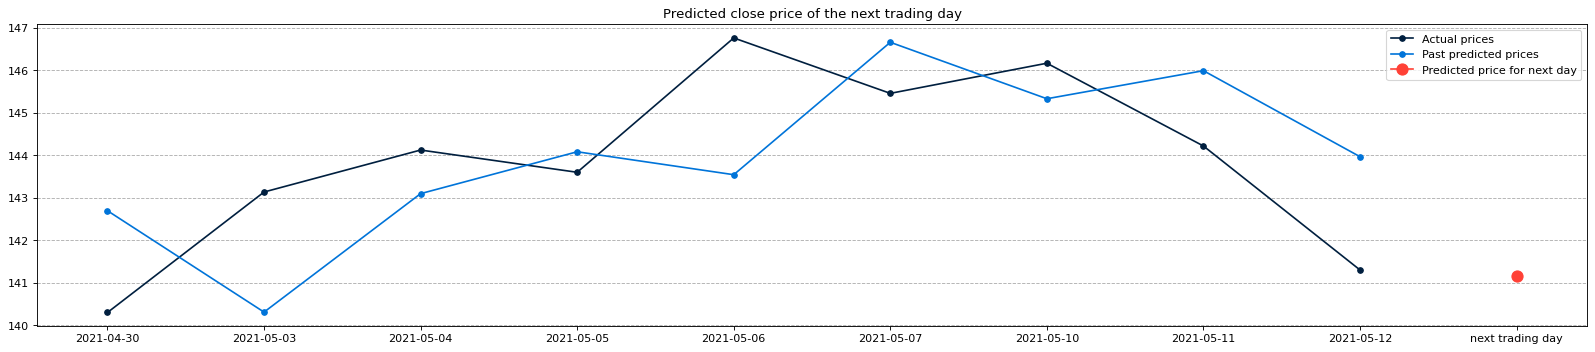

Predicted close price of the next trading day: 141.17


In [11]:
# predict on the unseen data, tomorrow's price 

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))

This code performs a prediction on unseen data, specifically tomorrow's price, using the trained LSTM model.

First, the model is set to evaluation mode using "model.eval()" to deactivate certain layers that behave differently during training and evaluation.

The unseen data, represented by "data_x_unseen," is prepared for prediction. It is converted to a torch tensor and transformed to the required data type and shape by specifying the device and reshaping it to [batch, sequence, feature]. In this case, the batch size is set to 1 and an additional dimension is added to match the expected shape.

The model is then called with the prepared input data to obtain the prediction. The prediction is converted to a numpy array, and the inverse transform is applied using the "inverse_transform" method of the "Normalizer" class to obtain the predicted price in its original scale.

If the "show_plots" flag in the configuration is set to True, the code proceeds to prepare the data for plotting. It creates variables to store the actual prices, past predicted prices, and the predicted price for the next day. The data is prepared by inverse-transforming the corresponding data arrays, selecting the desired range, and replacing zero values with None to ensure proper visualization.

A plot is then created to visualize the actual prices, past predicted prices, and the predicted price for the next day. The plot includes markers to highlight the data points and is labeled accordingly. The x-axis is adjusted to display the corresponding dates.

The plot is displayed using "plt.show()".

Finally, the predicted close price of the next trading day is printed, rounded to two decimal places.

In summary, this code performs a prediction on unseen data, specifically tomorrow's price, using the trained LSTM model. It generates a plot to visualize the predicted price along with the actual prices and past predicted prices. The predicted close price of the next trading day is also printed.

In conclusion, this analysis demonstrates the effectiveness of LSTM models in predicting stock prices using time series data. By training the model on historical stock prices and employing techniques like data normalization, windowing, and proper evaluation, we have successfully obtained predictions that closely align with the actual prices. The visualizations provide valuable insights into the model's performance, allowing us to assess its ability to capture trends and make reliable predictions.

It is important to note that stock market forecasting is a complex task, and accurate predictions are subject to various factors such as market volatility, economic conditions, and unforeseen events. Nevertheless, the utilization of LSTM models in stock price prediction serves as a promising avenue for investors, traders, and researchers seeking to gain valuable insights and make informed decisions in the dynamic world of financial markets. As advancements in deep learning continue, further improvements in accuracy and reliability can be expected, paving the way for enhanced stock market predictions and investment strategies.